<h2>NFDRS Version 4.0 Master Class</h2><br>
Series 1, 18 Jan 2022<br>
<hr>
Introduction to the Growing Season Index for Live Fuel Moistures



In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

Step 1: Read the FW21 data file from FireFamily+, strip spaces from the column headings and format the date as a Pandas DateTime data type.  Note: This is a complete, HOURLY data file.

In [2]:
fwx353228 = pd.read_csv("./Data/353228.fw21")
fwx353228.rename(columns=lambda x: x.strip(), inplace=True)
fwx353228['DateTime']=pd.to_datetime(fwx353228['DateTime'])
fwx353228.head()
#fwx353228

,DateTime,Temperature(F),RelativeHumidity(%),Precipitation(in),WindSpeed(mph),WindAzimuth(degrees),SolarRadiation(W/m2),SnowFlag,GustSpeed(mph),GustAzimuth(degrees)
0,1998-06-17 22:00:00+00:00,80.0,33.0,0.0,1.0,250.0,571.0,NaN,14.0,280.0
1,1998-06-17 23:00:00+00:00,72.0,36.0,0.0,7.0,336.0,359.0,NaN,16.0,1.0
2,1998-06-18 00:00:00+00:00,67.0,46.0,0.0,9.0,346.0,148.0,NaN,22.0,352.0
3,1998-06-18 01:00:00+00:00,63.0,55.0,0.0,14.0,353.0,37.0,NaN,23.0,335.0
4,1998-06-18 02:00:00+00:00,61.0,60.0,0.0,6.0,317.0,2.0,NaN,27.0,355.0


Step 2: EXPLORE - Let's make a plot the max, mean and min daily temperature

In [3]:
print(fwx353228.DateTime.min())
print(fwx353228.DateTime.max())

1998-06-17 22:00:00+00:00
2022-01-01 03:00:00+00:00


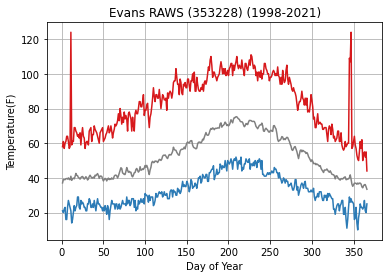

In [4]:
f,ax = plt.subplots()
fwx353228['Temperature(F)'].groupby(fwx353228.DateTime.dt.dayofyear).min().plot(ax=ax,color='#2c7bb6')
fwx353228['Temperature(F)'].groupby(fwx353228.DateTime.dt.dayofyear).mean().plot(ax=ax,color='grey')
fwx353228['Temperature(F)'].groupby(fwx353228.DateTime.dt.dayofyear).max().plot(ax=ax,color='#d7191c')
ax.set_xlabel("Day of Year")
ax.set_ylabel("Temperature(F)")
ax.set_title("Evans RAWS (353228) (1998-2021)")
plt.grid()

Note about colors:  Many standard color palettes are hard for many people to see. I like this website that has good, colorblind friendly palettes.  You can steal these colors and use directly anywhere in Python: https://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=11

In [5]:
# You can use this line to limit the data including the data frame.  
# This line will make sure we don't include any data from 2022.
fwx353228 = fwx353228[(fwx353228['DateTime'] <= '2021-12-31')]

Step 3: Let's calculate Photoperiod for our dataset....

In [6]:
# This function will calculate Photoperiod from Latitude and Day of Year

RADPERDAY = 0.017214
RADPERDEG = 0.01745329
MINDECL = -0.4092797
SECPERRAD = 13750.9871
DAYSOFF = 10.25

#Inputs: lat = Latitude in Degrees, yday is the day of the year.
#Returns: Daylength in seconds

def CalcDayl(lat,yday):
        # Daylength function from MT-CLIM */
        lat = lat * RADPERDEG
        if lat > 1.5707:
            lat = 1.5707
        if lat < -1.5707:
            lat = -1.5707
        coslat = cos(lat)
        sinlat = sin(lat)

        #* calculate cos and sin of declination */
        decl = MINDECL * cos((yday + DAYSOFF) * RADPERDAY)
        cosdecl = cos(decl)
        sindecl = sin(decl)
        cosegeom = coslat * cosdecl
        sinegeom = sinlat * sindecl
        coshss = -(sinegeom) / cosegeom
        if coshss < -1.0:
            coshss = -1.0  # 24-hr daylight */
        if coshss > 1.0:
            coshss = 1.0    # 0-hr daylight */
        hss = acos(coshss)                # hour angle at sunset (radians) */
        #* daylength (seconds) */
        return 2.0 * hss * SECPERRAD

In [7]:
# Test the CalcDayl function
CalcDayl(42.6,240) / 3600

13.145941694496848

In [8]:
# GSI Inputs are:
# Minimum Temperature (deg C)
# Vapor Pressure Deficit (Pascal)
# Daylength (Seconds)
# Running Total Precipitation (inches)

In [9]:
# Defaults for GSI are:
# Tmin: -2 to 5
# VPD: 900 to 4100
# Dayl: 36000 to 39600
#


In [10]:
# Compute and store the day of the year for use in calculating Daylength
fwx353228['JDay'] = fwx353228.DateTime.dt.dayofyear

In [11]:
# Loop through the dataframe and calcuate Daylength for each row
Lat = 42.6                               # Station Latitude in decimal degrees
Dayl = []                                # Create an empty list of data
for index, row in fwx353228.iterrows():  # Loop through the DataFrame.  Each interation pulls a 'row'
    jday = int(row.JDay)                 # Make sure to correct the data type
    Dayl.append(CalcDayl(Lat,jday))      # Calc Daylength and append to our list
fwx353228['Dayl'] = Dayl                 # Insert the list as a new column in the DataFrame

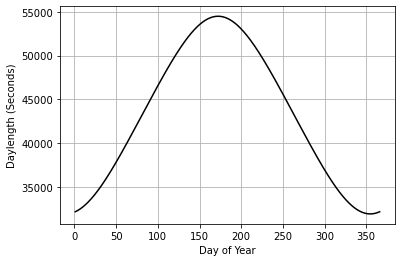

In [12]:
# Make a simple plot of Daylength. It doesn't change from year to year.
ax = fwx353228['Dayl'].groupby(fwx353228.DateTime.dt.dayofyear).mean().plot(color='black')
ax.set_xlabel("Day of Year")
ax.set_ylabel("Daylength (Seconds)")
plt.grid()

Step 4: Now let's compute VPDMax.  We need two functions to help us. 

In [13]:
# Function to calculate the Saturation Vapor Pressure for a given temperature.
# Note: Function converts internally from F to C.
def CalcVP(tempF):
    tmpC =  (tempF - 32.0) / 1.8
    vp = 610.7 * exp((17.38 * tmpC)/(239 + tmpC))
    return vp

# Calculate the VPD from RH and temperature
def CalcVPD(RH, TempF):
    vp = CalcVP(TempF)
    vpd = vp - (RH / 100) * vp
    if(vpd < 0.0):
        vpd = 0.0;
    return vpd

In [16]:
CalcVPD(50,75)

1481.4711094180602

In [17]:
# Use of resample requires us to set the DateTime as the Index
# This is a great reference for resample: 
# https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4
fwx353228_hourly = fwx353228.set_index('DateTime')

Tmin = pd.DataFrame({"Tmin": fwx353228_hourly['Temperature(F)'].resample('D').min()})  
Tmax = pd.DataFrame({"Tmax": fwx353228_hourly['Temperature(F)'].resample('D').max()})
Tavg = pd.DataFrame({"Tavg": fwx353228_hourly['Temperature(F)'].resample('D').mean()})
Dayl = pd.DataFrame({"Dayl": fwx353228_hourly['Dayl'].resample('D').mean()})
RHmin = pd.DataFrame({"RHmin": fwx353228_hourly['RelativeHumidity(%)'].resample('D').min()})
RHmax = pd.DataFrame({"RHmax": fwx353228_hourly['RelativeHumidity(%)'].resample('D').max()})
RHavg = pd.DataFrame({"RHavg": fwx353228_hourly['RelativeHumidity(%)'].resample('D').mean()})

In [18]:
fwx353228_daily = pd.concat([Tmax,Tmin,RHmax,RHmin,Dayl],axis=1)
fwx353228_daily['DateTime'] = fwx353228_daily.index
fwx353228_daily = fwx353228_daily.dropna()

In [19]:
# Loop through DataFrame and calculate VPD, just like before
VPD = []  # Empty Array
for index, row in fwx353228_daily.iterrows():
    temp = float(row.Tmax)
    rh = float(row.RHmin)
    VPD.append(CalcVPD(rh,temp) )
fwx353228_daily['VPDMax'] = VPD

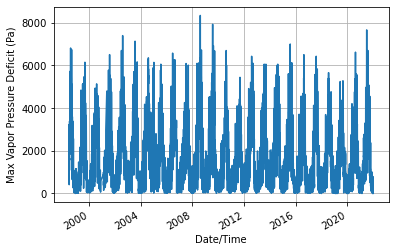

In [20]:
ax = fwx353228_daily.VPDMax.plot()
ax.set_xlabel("Date/Time")
ax.set_ylabel("Max Vapor Pressure Deficit (Pa)")
plt.grid()

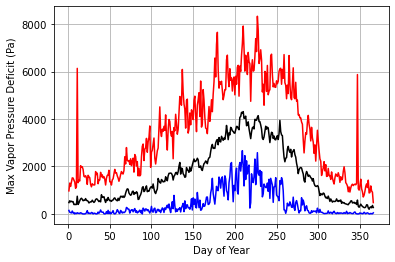

In [21]:
f,ax = plt.subplots()
fwx353228_daily.VPDMax.groupby(fwx353228_daily.DateTime.dt.dayofyear).mean().plot(ax=ax,color='black')
fwx353228_daily.VPDMax.groupby(fwx353228_daily.DateTime.dt.dayofyear).min().plot(ax=ax,color='blue')
fwx353228_daily.VPDMax.groupby(fwx353228_daily.DateTime.dt.dayofyear).max().plot(ax=ax,color='red')
ax.set_xlabel("Day of Year")
ax.set_ylabel("Max Vapor Pressure Deficit (Pa)")
plt.grid()

Step 5: Finally, let's calculate one of the Indicator or Ramp functions for one of the variables.

In [22]:
fwx353228_daily['TminC'] =  (fwx353228_daily.Tmin - 32.0) * 5.0 / 9.0; # Convert Tmin from Fahrenheit to celcuius

In [23]:
# Here is an easy way to look for crazy values.  Let's look at the days in the dataset that have TempF greater than 120F
fwx353228_daily[fwx353228_daily['Tmax'] > 120]

,Tmax,Tmin,RHmax,RHmin,Dayl,DateTime,VPDMax,TminC
DateTime,,,,,,,,
2004-12-12 00:00:00+00:00,124.0,54.0,100.0,55.0,32035.177999,2004-12-12 00:00:00+00:00,5872.682179,12.222222
2005-01-11 00:00:00+00:00,124.0,26.0,95.0,53.0,32787.518220,2005-01-11 00:00:00+00:00,6133.690276,-3.333333


Here is a good article on ways to drop data from the DataFrame
https://www.datasciencemadesimple.com/drop-delete-rows-conditions-python-pandas/

In [24]:
# GSI indicator/ramp function
def Ind(Var,Low,Up):
    # Make sure all the input variables are numbers
    Var = float(Var)
    Low = float(Low)
    Up = float(Up)
    if(Up == Low):  # Upper (Up) and Lower (Low) can't be the same
        return 0
    if( Var < Low):  # If the variables is less than the lower limit, return 0
        return 0
    elif(Var > Up):  # If the variables is greater than the upper limit, return 1
        return 1
    else:            # If the variables is between the lower and upper limits, return the proportion
        return (Var - Low) / (Up - Low)

In [25]:
# Test the GSI Indicator / Ramp Function
Ind(-1.9,-2,5)

0.0142857142857143

In [26]:
# Test the indicator function over a range of temperature
t = [-3,-2,-1,0,1,2,3,4,5,6,7]
ind = []
for v in t:
    ind.append(Ind(v,-2,5))

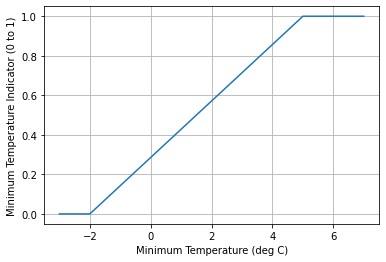

In [27]:
f,ax = plt.subplots()
ax.plot(t,ind)
ax.set_xlabel("Minimum Temperature (deg C)")
ax.set_ylabel("Minimum Temperature Indicator (0 to 1)")
plt.grid()

In [28]:
TminInd = []  # Empty Array
TminLow = -2        # Lower limit for Minimum Temperature (-2degC by default)
TminUp = 5          # Upper limit for Minimum Temperature (5degC by default)
for index, row in fwx353228_daily.iterrows():
    temp = float(row.TminC)
    TminInd.append(Ind(temp,TminLow,TminUp))
fwx353228_daily['TminInd'] = TminInd

In [29]:
fwx353228_daily['TminInd'] = fwx353228_daily.apply(lambda row: Ind(row['TminC'],TminLow,TminUp),axis=1)

Text(0, 0.5, 'Minimum Temperature Indicator (0 to 1)')

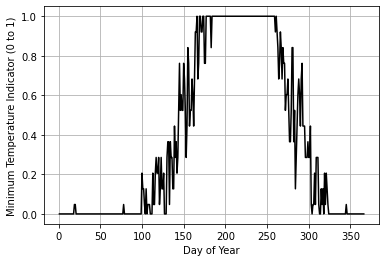

In [32]:
f,ax = plt.subplots()
fwx353228_daily.TminInd.groupby(fwx353228_daily.DateTime.dt.dayofyear).min().plot(color='black')
plt.grid()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Minimum Temperature Indicator (0 to 1)")